In [39]:
!python -V


Python 3.9.12


In [40]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [41]:
!pwd

/home/jovyan/work/MLOPS_Zoomcamp/Week1


In [42]:
!ls

data  duration_prediction.ipynb


## Q1. Downloading the data

In [43]:
df_jan = pd.read_parquet('data/fhv_tripdata_2021-01.parquet')



In [44]:
df_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [45]:
df_jan.columns

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number'],
      dtype='object')

In [46]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In [47]:
df_jan.isnull().sum()


dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID               958267
DOlocationID               162220
SR_Flag                   1154112
Affiliated_base_number        885
dtype: int64

In [48]:
df_jan.nunique()


dispatching_base_num         539
pickup_datetime           807066
dropOff_datetime          812640
PUlocationID                 261
DOlocationID                 262
SR_Flag                        0
Affiliated_base_number       705
dtype: int64

## Q2. Computing duration

In [49]:
df_jan['duration'] = df_jan.dropOff_datetime - df_jan.pickup_datetime


In [50]:
df_jan['duration'].describe()

count                      1154112
mean     0 days 00:19:10.033445627
std      0 days 06:38:41.529882844
min                0 days 00:00:01
25%                0 days 00:07:46
50%                0 days 00:13:24
75%                0 days 00:22:17
max              294 days 00:11:03
Name: duration, dtype: object

In [51]:
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds() / 60)


In [52]:
#remove aoutliers from duration column (Keep duration between 1 and 60 min inclusive)
df_jan = df_jan[(df_jan.duration >= 1) & (df_jan.duration <= 60)]


In [53]:
len(df_jan)

1109826

In [54]:
1154112 - 1109826
#we dropped 44286 records

44286

## Q3. Missing values

In [55]:
categorical = ["PUlocationID","DOlocationID"]
train_df = df_jan[categorical + ["duration"]]
train_df.head()

,PUlocationID,DOlocationID,duration
0,NaN,NaN,17.000000
1,NaN,NaN,17.000000
3,NaN,72.0,8.283333
4,NaN,61.0,15.216667
5,NaN,71.0,9.050000


In [56]:
train_df.fillna(-1, inplace = True)
train_df.head()

/tmp/ipykernel_102/3953750351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.fillna(-1, inplace = True)


,PUlocationID,DOlocationID,duration
0,-1.0,-1.0,17.000000
1,-1.0,-1.0,17.000000
3,-1.0,72.0,8.283333
4,-1.0,61.0,15.216667
5,-1.0,71.0,9.050000


In [57]:
train_df[categorical]= train_df[categorical].astype("str")


/tmp/ipykernel_102/4151475405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[categorical]= train_df[categorical].astype("str")


In [37]:
#fraction of -1 in PUIlocationID
(train_df.PUlocationID == "-1.0").sum()/len(train_df)

0.8352732770722617

## Q4. One-hot encoding

In [58]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [65]:
X_train = train_df.iloc[:,:2]
train_dicts = X_train.to_dict(orient='records')
train_dicts = X_train.to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [66]:
X_train.shape

(1109826, 525)

## Q5. Training a model

In [67]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
#mse
mean_squared_error(y_train, y_pred, squared=False)

10.528519388157976

## Q6. Evaluating the model

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


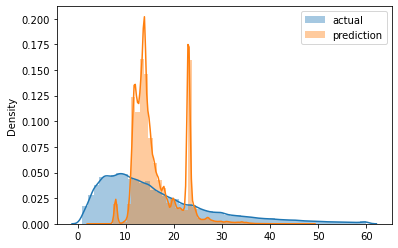

In [68]:
sns.distplot(y_train , label = "actual")
sns.distplot(y_pred, label = "prediction")
plt.legend()

In [69]:
def test_process(dataframe):
    dataframe["duration"] = (dataframe.dropOff_datetime - dataframe.pickup_datetime).dt.total_seconds().div(60)
    dataframe = dataframe[(dataframe.duration >= 1) & (dataframe.duration <= 60)]
    categorical = ["PUlocationID","DOlocationID"]
    dataframe = dataframe[categorical + ["duration"]]
    dataframe.fillna(-1, inplace = True)
    dataframe[categorical]= dataframe[categorical].astype("str")
    X_val = dataframe.iloc[:,:2]
    y_val = dataframe.iloc[:,2].values
    X_val_dict = X_val.to_dict(orient = "records")
    return dv.transform(X_val_dict) , y_val

In [70]:
df_feb = pd.read_parquet('data/fhv_tripdata_2021-02.parquet')

In [71]:
X_val , y_val = test_process(df_feb)
X_val.shape

(990113, 525)

In [72]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val,y_pred, squared = False)

11.01428627530246

In [73]:
pwd

'/home/jovyan/work/MLOPS_Zoomcamp/Week1'

In [74]:
#save model
with open("models/linear_regression.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [75]:
!zip -r week1.zip MLOPS_Zoomcamp

/bin/bash: zip: command not found
